In [1]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
import h5py
from tqdm import tqdm
import webdataset as wds

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator, DeepSpeedPlugin

from sentence_transformers import SentenceTransformer, util
from transformers import CLIPModel, AutoTokenizer, AutoProcessor
import evaluate
import pandas as pd

from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder
from models import GNet8_Encoder, Clipper

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

### Multi-GPU config ###
local_rank = os.getenv('RANK')
if local_rank is None: 
    local_rank = 0
else:
    local_rank = int(local_rank)
print("LOCAL RANK ", local_rank)  

accelerator = Accelerator(split_batches=False, mixed_precision="fp16") # ['no', 'fp8', 'fp16', 'bf16']

print("PID of this process =",os.getpid())
device = accelerator.device
print("device:",device)
world_size = accelerator.state.num_processes
distributed = not accelerator.state.distributed_type == 'NO'
num_devices = torch.cuda.device_count()
if num_devices==0 or not distributed: num_devices = 1
num_workers = num_devices
print(accelerator.state)

print("distributed =",distributed, "num_devices =", num_devices, "local rank =", local_rank, "world size =", world_size)
print = accelerator.print # only print if local_rank=0

LOCAL RANK  0
PID of this process = 3801992
device: cuda
Distributed environment: DistributedType.NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

distributed = False num_devices = 1 local rank = 0 world size = 1


In [2]:
# if running this interactively, can specify jupyter_args here for argparser to use
if utils.is_interactive():
    model_name = "pretrained_subj01_40sess_hypatia_vd2"
    # model_name = "pretest_pretrained_subj01_40sess_hypatia_pg_sessions40"
    mode = "imagery"
    # all_recons_path = f"evals/{model_name}/{model_name}_all_enhancedrecons_{mode}.pt"
    all_recons_path = f"evals/{model_name}/{model_name}_all_recons_{mode}.pt"
    
    imagery_data_path = "/weka/proj-medarc/shared/umn-imagery"
    cache_dir = "/weka/proj-medarc/shared/cache"
    data_path = "/weka/proj-medarc/shared/mindeyev2_dataset"
    criteria = "Brain*Corr.*nsd_general"
    # criteria = "SSIM"
    print("model_name:", model_name)

    jupyter_args = f"--model_name={model_name} --data_path={data_path} --cache_dir={cache_dir} --all_recons_path={all_recons_path} --mode {mode} \
                        --imagery_data_path={imagery_data_path} --criteria={criteria}"
    print(jupyter_args)
    jupyter_args = jupyter_args.split()
    
    from IPython.display import clear_output # function to clear print outputs in cell
    %load_ext autoreload 
    # this allows you to change functions in models.py or utils.py and have this notebook automatically update with your revisions
    %autoreload 2 

model_name: pretrained_subj01_40sess_hypatia_vd2
--model_name=pretrained_subj01_40sess_hypatia_vd2 --data_path=/weka/proj-medarc/shared/mindeyev2_dataset --cache_dir=/weka/proj-medarc/shared/cache --all_recons_path=evals/pretrained_subj01_40sess_hypatia_vd2/pretrained_subj01_40sess_hypatia_vd2_all_recons_imagery.pt --mode imagery                         --imagery_data_path=/weka/proj-medarc/shared/umn-imagery --criteria=Brain*Corr.*nsd_general


In [3]:
parser = argparse.ArgumentParser(description="Model Training Configuration")
parser.add_argument(
    "--model_name", type=str, default="testing",
    help="name of model, used for ckpt saving and wandb logging (if enabled)",
)
parser.add_argument(
    "--all_recons_path", type=str,
    help="Path to where all_recons.pt is stored",
)
parser.add_argument(
    "--data_path", type=str, default=os.getcwd(),
    help="Path to where NSD data is stored / where to download it to",
)
parser.add_argument(
    "--cache_dir", type=str, default=os.getcwd(),
    help="Path to where misc. files downloaded from huggingface are stored. Defaults to current src directory.",
)
parser.add_argument(
    "--subjs",type=str, default='1,2,5,7',
    help="Evaluate on which subject?",
)
parser.add_argument(
    "--mode",type=str,default="vision",
)
parser.add_argument(
    "--seed",type=int,default=42,
)
parser.add_argument(
    "--blurry_recon",action=argparse.BooleanOptionalAction,default=True,
)
parser.add_argument(
    "--imagery_data_path",type=str
)
parser.add_argument(
    "--criteria",type=str, default="all",
)

if utils.is_interactive():
    args = parser.parse_args(jupyter_args)
else:
    args = parser.parse_args()

# create global variables without the args prefix
for attribute_name in vars(args).keys():
    globals()[attribute_name] = getattr(args, attribute_name)

criteria = criteria.replace("*", " ")
# seed all random functions
utils.seed_everything(seed)

# Loading tables

In [4]:
if mode == "synthetic":
    all_images = torch.zeros((284, 3, 714, 1360))
    all_images[:220] = torch.load(f"{imagery_data_path}/nsddata_stimuli/stimuli/nsdsynthetic/nsd_synthetic_stim_part1.pt")
    #The last 64 stimuli are slightly different for each subject, so we load these separately for each subject
    all_images[220:] = torch.load(f"{imagery_data_path}/nsddata_stimuli/stimuli/nsdsynthetic/nsd_synthetic_stim_part2_sub{subj}.pt")
else:
    all_images = torch.load(f"{imagery_data_path}/nsddata_stimuli/stimuli/imagery_stimuli_18.pt")

In [5]:
subjects = [int(s) for s in subjs.split(",")]
print("subjects:", subjects)
ms_model_names = []
ms_all_recons_paths = []
for subj in subjects:
    m_name = model_name.replace("subj01", f"subj{subj:02d}")
    ms_model_names.append(m_name)
    ms_all_recons_paths.append(all_recons_path.replace("subj01", f"subj{subj:02d}"))    
print("ms_model_names:", ms_model_names)
print("ms_all_recons_paths:", ms_all_recons_paths)

subjects: [1, 2, 5, 7]
ms_model_names: ['pretrained_subj01_40sess_hypatia_vd2', 'pretrained_subj02_40sess_hypatia_vd2', 'pretrained_subj05_40sess_hypatia_vd2', 'pretrained_subj07_40sess_hypatia_vd2']
ms_all_recons_paths: ['evals/pretrained_subj01_40sess_hypatia_vd2/pretrained_subj01_40sess_hypatia_vd2_all_recons_imagery.pt', 'evals/pretrained_subj02_40sess_hypatia_vd2/pretrained_subj02_40sess_hypatia_vd2_all_recons_imagery.pt', 'evals/pretrained_subj05_40sess_hypatia_vd2/pretrained_subj05_40sess_hypatia_vd2_all_recons_imagery.pt', 'evals/pretrained_subj07_40sess_hypatia_vd2/pretrained_subj07_40sess_hypatia_vd2_all_recons_imagery.pt']


In [6]:
ms_all_metrics = []
ms_all_recons = []

for m_name, m_all_recons_path, subj in zip(ms_model_names, ms_all_recons_paths, subjects):
    all_recons = torch.load(m_all_recons_path)
    ms_all_recons.append(all_recons)
    print(f"Loaded {m_all_recons_path} with shape {all_recons.shape}")
    
    all_metric_table = pd.read_csv(f"tables/{m_name}_all_recons_{mode}.csv", sep="\t")

    # add a column with all values the subject 
    all_metric_table["Subject"] = [subj]*len(all_metric_table)

    ms_all_metrics.append(all_metric_table)
    print(f"Loaded tables/{m_name}_all_recons_{mode}.csv")



Loaded evals/pretrained_subj01_40sess_hypatia_vd2/pretrained_subj01_40sess_hypatia_vd2_all_recons_imagery.pt with shape torch.Size([18, 10, 3, 512, 512])
Loaded tables/pretrained_subj01_40sess_hypatia_vd2_all_recons_imagery.csv
Loaded evals/pretrained_subj02_40sess_hypatia_vd2/pretrained_subj02_40sess_hypatia_vd2_all_recons_imagery.pt with shape torch.Size([18, 10, 3, 512, 512])
Loaded tables/pretrained_subj02_40sess_hypatia_vd2_all_recons_imagery.csv
Loaded evals/pretrained_subj05_40sess_hypatia_vd2/pretrained_subj05_40sess_hypatia_vd2_all_recons_imagery.pt with shape torch.Size([18, 10, 3, 512, 512])
Loaded tables/pretrained_subj05_40sess_hypatia_vd2_all_recons_imagery.csv
Loaded evals/pretrained_subj07_40sess_hypatia_vd2/pretrained_subj07_40sess_hypatia_vd2_all_recons_imagery.pt with shape torch.Size([18, 10, 3, 512, 512])
Loaded tables/pretrained_subj07_40sess_hypatia_vd2_all_recons_imagery.csv


In [7]:
# concatename all the metrics vertically
all_metrics = pd.concat(ms_all_metrics)
all_metrics

,Unnamed: 0,index_sample,PixCorr,SSIM,AlexNet(2),AlexNet(5),InceptionV3,CLIP,EffNet-B,SwAV,FwdRetrieval,BwdRetrieval,Brain Corr. nsd_general,Brain Corr. V1,Brain Corr. V2,Brain Corr. V3,Brain Corr. V4,Brain Corr. higher_vis,index_image,Subject
0,0,0,0.066955,0.384511,NaN,NaN,NaN,NaN,1.040304,0.596045,NaN,NaN,0.176575,0.136698,0.160578,0.283312,0.155166,0.157243,0,1
1,1,0,0.113482,0.374864,NaN,NaN,NaN,NaN,1.057766,0.646304,NaN,NaN,-0.048239,-0.024426,0.007181,-0.005020,-0.000395,-0.029165,1,1
2,2,0,0.082974,0.414274,NaN,NaN,NaN,NaN,1.037150,0.545348,NaN,NaN,0.149387,0.172684,0.176839,0.222730,0.153636,0.117270,2,1
3,3,0,-0.084677,0.431340,NaN,NaN,NaN,NaN,0.975514,0.561306,NaN,NaN,-0.059817,0.186079,0.068785,-0.061980,-0.099542,-0.107000,3,1
4,4,0,0.014242,0.399044,NaN,NaN,NaN,NaN,1.006163,0.632921,NaN,NaN,0.250494,0.160623,0.300641,0.268930,0.219722,0.245069,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,9,0.335510,0.237982,NaN,NaN,NaN,NaN,0.910773,0.648744,NaN,NaN,0.091103,0.104209,0.208490,0.006777,0.012697,0.085718,7,7
116,116,9,0.131395,0.207448,NaN,NaN,NaN,NaN,1.009742,0.515519,NaN,NaN,-0.031867,-0.022046,-0.059523,0.020840,-0.029752,-0.084847,8,7
117,117,9,0.076354,0.184964,NaN,NaN,NaN,NaN,0.925857,0.520415,NaN,NaN,0.118681,0.186343,0.118071,0.140822,-0.174148,0.086463,9,7
118,118,9,0.037643,0.269121,NaN,NaN,NaN,NaN,0.898989,0.545183,NaN,NaN,0.033890,-0.072654,0.127792,0.099090,0.058935,0.040623,10,7


In [8]:
def get_best_and_medium(df, criteria):
    if criteria == "all":
        # Average all metrics
        scores = df.mean(axis=1)
    elif isinstance(criteria, str):
        # Handle the case where criteria is a single string
        scores = df[criteria]
    else:
        # Handle the case where criteria is a list of columns
        scores = df[criteria].mean(axis=1)
    
    # Get the index of the best score (highest)
    best_index = scores.idxmax()
    
    # Get the index of the median score
    median_index = scores.sort_values().index[len(scores) // 2]
    
    # Return the best and median rows
    best_row = df.iloc[best_index]
    median_row = df.iloc[median_index]
    
    return best_row, median_row

# Example usage:
# criteria = ["AlexNet(2)", "SSIM"]  # list of columns
# criteria = "AlexNet(2)"  # single string
# best_row, median_row = get_best_and_medium(df, criteria)

# print("Best sample row:\n", best_row)
# print("Median sample row:\n", median_row)


In [9]:
# current_image_metrics['Brain Corr. nsd_general']

In [10]:
# selected_row_median

In [11]:
selected_best_final_images = []
selected_median_final_images = []
for current_image_index, i in enumerate(all_images[:12]):
    # select all the rows with the current image index
    current_image_metrics = all_metrics[all_metrics["index_image"] == current_image_index].reset_index()
    # convert current_image_metrics to a dataframe
    # current_image_metrics = pd.DataFrame(current_image_metrics)

    selected_row_best, selected_row_median = get_best_and_medium(current_image_metrics, criteria)

    # selected_row_best = current_image_metrics.loc[best_index]
    # print(selected_row_best)
    # selected_row_median = current_image_metrics.loc[median_index]

    selected_subject_best = selected_row_best["Subject"]
    selected_subject_median = selected_row_median["Subject"]

    # this is in the second column of the table
    selected_sample_best = selected_row_best["index_sample"]
    selected_sample_median = selected_row_median["index_sample"]

    selected_subject_best_index = subjects.index(selected_subject_best)
    selected_subject_median_index = subjects.index(selected_subject_median)

    # print(ms_all_recons[selected_subject_best_index].shape, selected_sample_best, current_image_index)
    print(selected_subject_best, selected_sample_best)
    selected_best_final_images.append(ms_all_recons[selected_subject_best_index][current_image_index][int(selected_sample_best)])
    selected_median_final_images.append(ms_all_recons[selected_subject_median_index][current_image_index][int(selected_sample_median)])


7.0 5.0
5.0 5.0
7.0 7.0
2.0 4.0
1.0 0.0
1.0 4.0
2.0 9.0
1.0 0.0
2.0 4.0
2.0 8.0
2.0 5.0
2.0 2.0


In [12]:
# current_image_metrics = all_metrics[all_metrics["index_image"] == 0].reset_index()

In [13]:
# ms_all_recons[0].shape

In [14]:
# current_image_metrics

In [15]:
all_recons_best = torch.stack(selected_best_final_images)
all_recons_median = torch.stack(selected_median_final_images)

In [16]:
all_images.shape

torch.Size([18, 3, 425, 425])

In [17]:
from PIL import Image
import torch
from torchvision import transforms

imsize = 150

def resize_with_padding(image, target_size):
    # Get the size difference between target size and current image size
    current_size = image.shape[-2:]
    padding = [max(0, (target_size[i] - current_size[i])) // 2 for i in range(2)]
    
    # Pad both sides equally (top/bottom and left/right)
    transform = transforms.Compose([
        transforms.Resize(target_size),  # Resize to target size while maintaining aspect ratio
        transforms.Pad((padding[1], padding[0], padding[1], padding[0]), fill=0)  # Pad to target size, avoiding negative padding
    ])
    return transform(image)

def save_plot(all_images, all_recons, name):
    # Resize images without cropping and maintain aspect ratio with padding
    if all_images.shape[-1] != imsize:
        all_images = resize_with_padding(all_images, (imsize, imsize)).float()
    if all_recons.shape[-1] != imsize:
        all_recons = resize_with_padding(all_recons, (imsize, imsize)).float()
    
    num_images = all_recons.shape[0]
    num_rows = (2 * num_images + 11) // 12
    
    # Interleave tensors
    merged = torch.stack([val for pair in zip(all_images, all_recons) for val in pair], dim=0)
    
    # Calculate grid size
    grid = torch.zeros((num_rows * 12, 3, imsize, imsize))
    
    # Populate the grid
    grid[:2*num_images] = merged
    grid_images = [transforms.functional.to_pil_image(grid[i]) for i in range(num_rows * 12)]
    
    # Create the grid image
    grid_image = Image.new('RGB', (imsize * 12, imsize * num_rows))  # 12 images wide
    
    # Paste images into the grid
    for i, img in enumerate(grid_images):
        grid_image.paste(img, (imsize * (i % 12), imsize * (i // 12)))
    
    grid_image.save(f"../figs/{model_name_plus_suffix}_{len(all_recons)}recons_{name}_{mode}_{criteria}.png")


In [18]:
model_name_plus_suffix = model_name.replace("subj01", f"subj{[str(s) for s in subjects]}")

save_plot(all_images[:12], all_recons_best, "best_multisubject")
save_plot(all_images[:12], all_recons_median, "median_multisubject")

/admin/home-ckadirt/mindeye/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


### 

In [19]:
# # Create a dictionary to store variable names and their corresponding values
# import pandas as pd
# data = {
#     "Metric": ["PixCorr", "SSIM", "AlexNet(2)", "AlexNet(5)", "InceptionV3", "CLIP", "EffNet-B", "SwAV", "FwdRetrieval", "BwdRetrieval",
#                "Brain Corr. nsd_general", "Brain Corr. V1", "Brain Corr. V2", "Brain Corr. V3", "Brain Corr. V4",  "Brain Corr. higher_vis"],
#     "Value": [pixcorr, ssim, alexnet2, alexnet5, inception, clip_, effnet, swav, percent_correct_fwd, percent_correct_bwd, 
#               region_brain_correlations["nsd_general"], region_brain_correlations["V1"], region_brain_correlations["V2"], region_brain_correlations["V3"], region_brain_correlations["V4"], region_brain_correlations["higher_vis"]]}

# df = pd.DataFrame(data)
# print(model_name_plus_suffix)
# print(df.to_string(index=False))
# print(df["Value"].to_string(index=False))

# # save table to txt file
# os.makedirs('tables/',exist_ok=True)
# df["Value"].to_csv(f'tables/{model_name_plus_suffix}.csv', sep='\t', index=False)

In [20]:
# every_to_plot_0 = None
# for i in ms_all_recons:
#     set_samples = i[1] # shape 10, 3, 512, 512
#     if every_to_plot_0 is None:
#         every_to_plot_0 = set_samples
#     else:
#         every_to_plot_0 = torch.cat((every_to_plot_0, set_samples), 0)

# print(every_to_plot_0.shape)

In [21]:
# current_image_metrics['Brain Corr. higher_vis']

In [22]:
# current_image_metrics['Brain Corr. higher_vis']

torch.Size([40, 3, 512, 512])


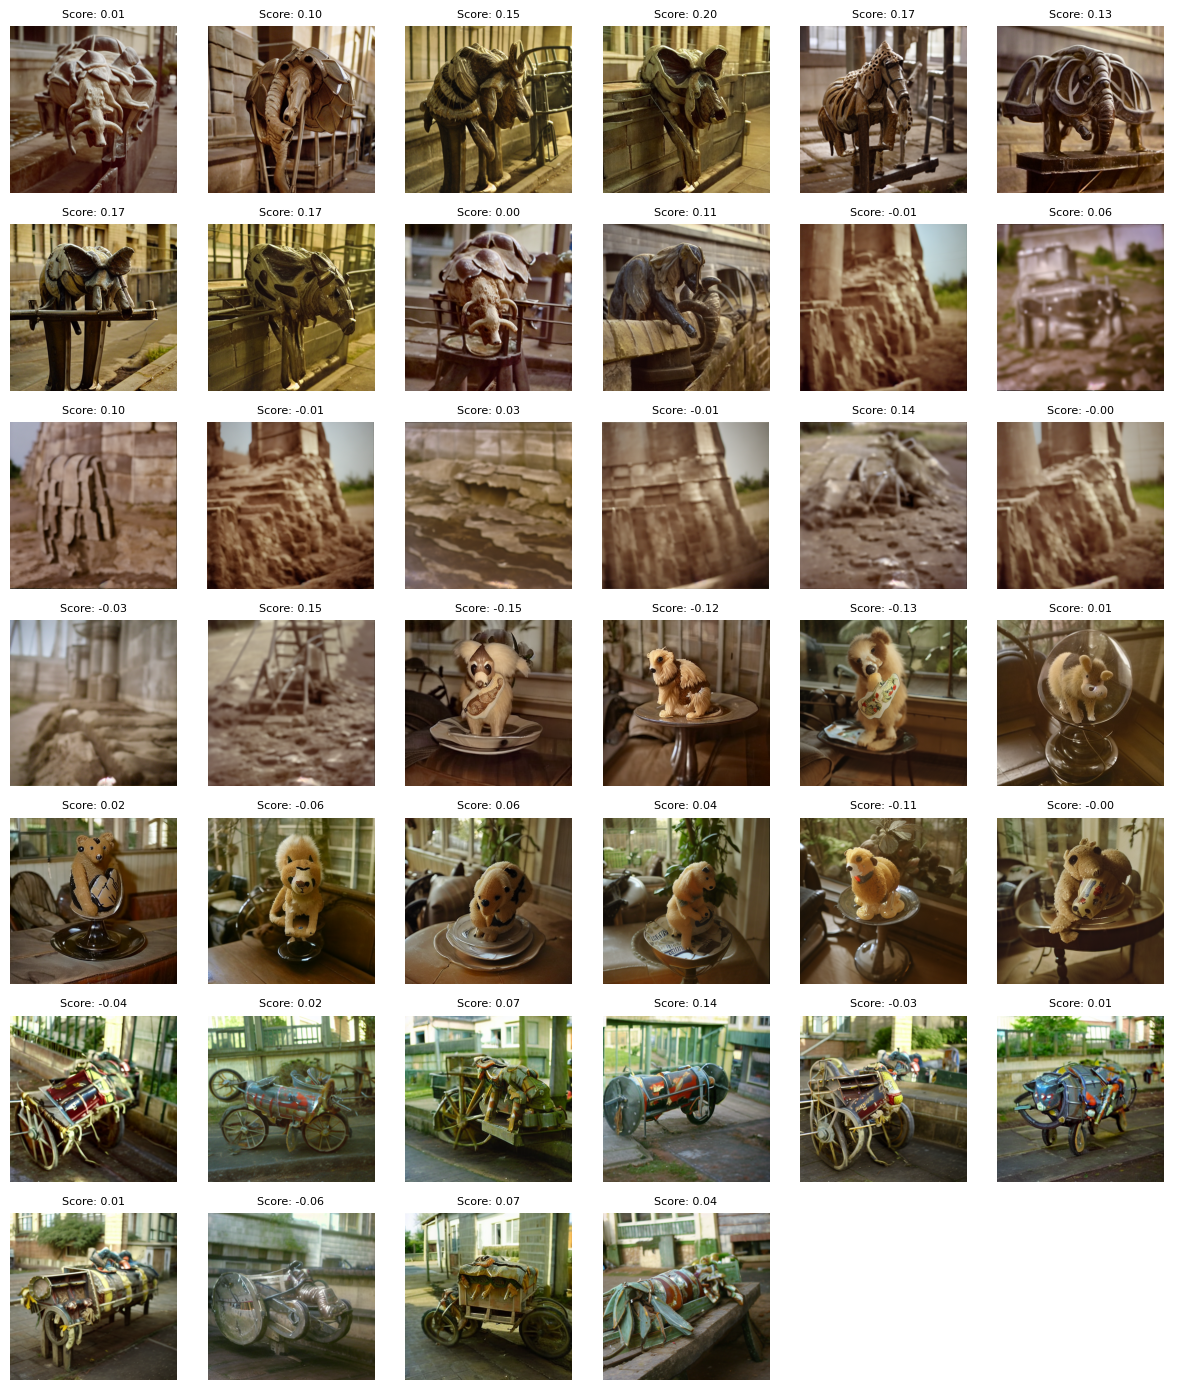

In [42]:
# import matplotlib.pyplot as plt
# import torch

# iiii = 4

# every_to_plot_0 = None
# for i in ms_all_recons:
#     set_samples = i[iiii]  # shape 10, 3, 512, 512
#     if every_to_plot_0 is None:
#         every_to_plot_0 = set_samples
#     else:
#         every_to_plot_0 = torch.cat((every_to_plot_0, set_samples), 0)

# print(every_to_plot_0.shape)

# current_image_metrics = all_metrics[all_metrics["index_image"] == iiii].reset_index()
# scores_values = current_image_metrics['PixCorr'].values  # Get the score values

# # Plot all images in a grid with dynamic columns and annotate with score values
# def plot_images(images, scores, num_rows=10):
#     num_images = len(images)
#     num_cols = (num_images + num_rows - 1) // num_rows  # Calculate the number of columns

#     fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 2, num_rows * 2))
#     axs = axs.flatten()  # Flatten the axes array for easier indexing

#     for idx, image in enumerate(images):
#         axs[idx].imshow(image.permute(1, 2, 0))  # Plot image
#         axs[idx].axis('off')  # Remove axis
#         axs[idx].set_title(f"Score: {scores[idx]:.2f}", fontsize=8)  # Add score as the title

#     # Hide any unused subplots
#     for i in range(len(images), len(axs)):
#         axs[i].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Example usage
# plot_images(every_to_plot_0.cpu().float(), scores_values, num_rows=7)


In [28]:
# preprocess_pixcorr = transforms.Compose([
#     transforms.Resize(425, interpolation=transforms.InterpolationMode.BILINEAR),
# ])

# def get_pix_corr(all_images, all_recons):

    
#     # Flatten images while keeping the batch dimension
#     all_images_flattened = preprocess_pixcorr(all_images).reshape(len(all_images), -1).cpu()
#     all_recons_flattened = preprocess_pixcorr(all_recons).view(len(all_recons), -1).cpu()
    
#     print(all_images_flattened.shape)
#     print(all_recons_flattened.shape)
    
#     corrsum = 0
#     for i in tqdm(range(len(all_images))):
#         corrsum += np.corrcoef(all_images_flattened[i], all_recons_flattened[i])[0][1]
#     corrmean = corrsum / len(all_images)
    
#     pixcorr = corrmean
#     print(pixcorr)
#     return pixcorr

In [44]:
# get_pix_corr(all_images[4],every_to_plot_0[1])

torch.Size([3, 180625])
torch.Size([3, 180625])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 517.62it/s]

0.1098579229384062


0.1098579229384062